# Preprocessing
## Imputation: Mean, KNN, etc.
## Feature selection: Based on correlation coefficients

# 0. Importing

In [1]:
import pandas as pd
import numpy as np

#from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score

#from sklearn.decomposition import PCA
#from sklearn.preprocessing import StandardScaler

#import shap
from sklearn.ensemble import RandomForestRegressor
#from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, SimpleImputer, IterativeImputer

import matplotlib
from matplotlib import pyplot as plt

#import seaborn as sns
#from scipy.stats import pearsonr
#from scipy.stats import ks_2samp

import time

In [2]:
matplotlib.rcParams['font.family'] = 'Liberation Sans'

# 1. Reading data

In [3]:
raw_data = pd.read_csv("../dataset/GT_features_all.csv")

data_gender = pd.DataFrame(np.array(raw_data['Gender']=='F'), columns=['Gender_isFemale'])
raw_numeric = raw_data.drop(['Gender','Competition','Name'],axis=1)
raw_data_numerized = pd.concat([raw_numeric, data_gender], axis=1, join='inner')
#print(raw_data_numerized.shape)

raw_data_numerized_M = raw_data_numerized[raw_data_numerized['Gender_isFemale']==False].drop(['Gender_isFemale'],axis=1).reset_index(drop=True)
raw_data_numerized_F = raw_data_numerized[raw_data_numerized['Gender_isFemale']==True].drop(['Gender_isFemale'],axis=1).reset_index(drop=True)
#print(raw_data_numerized_M.shape, raw_data_numerized_F.shape)

# Visualization: Missing data, data distributions

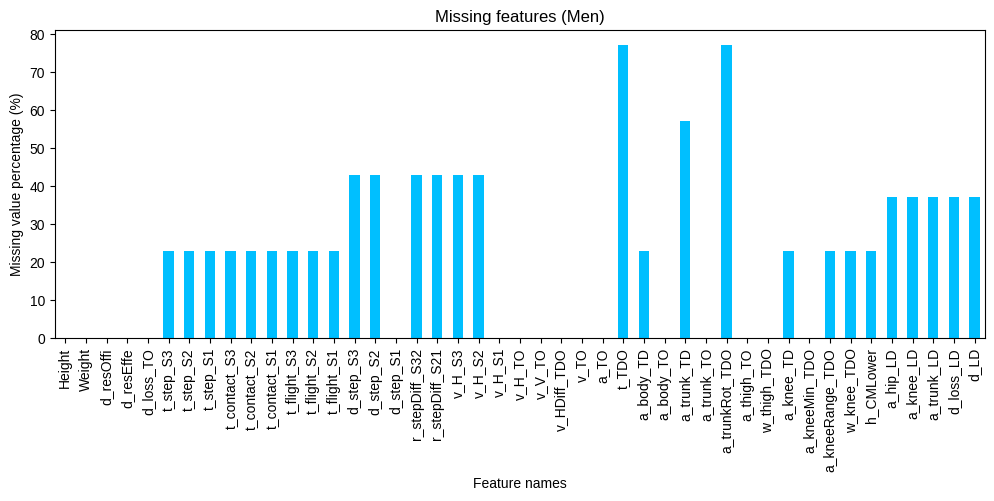

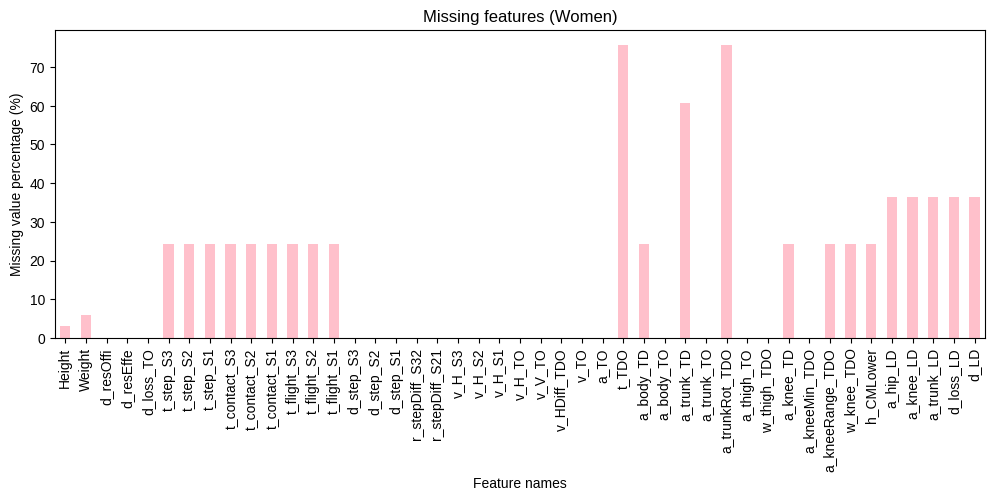

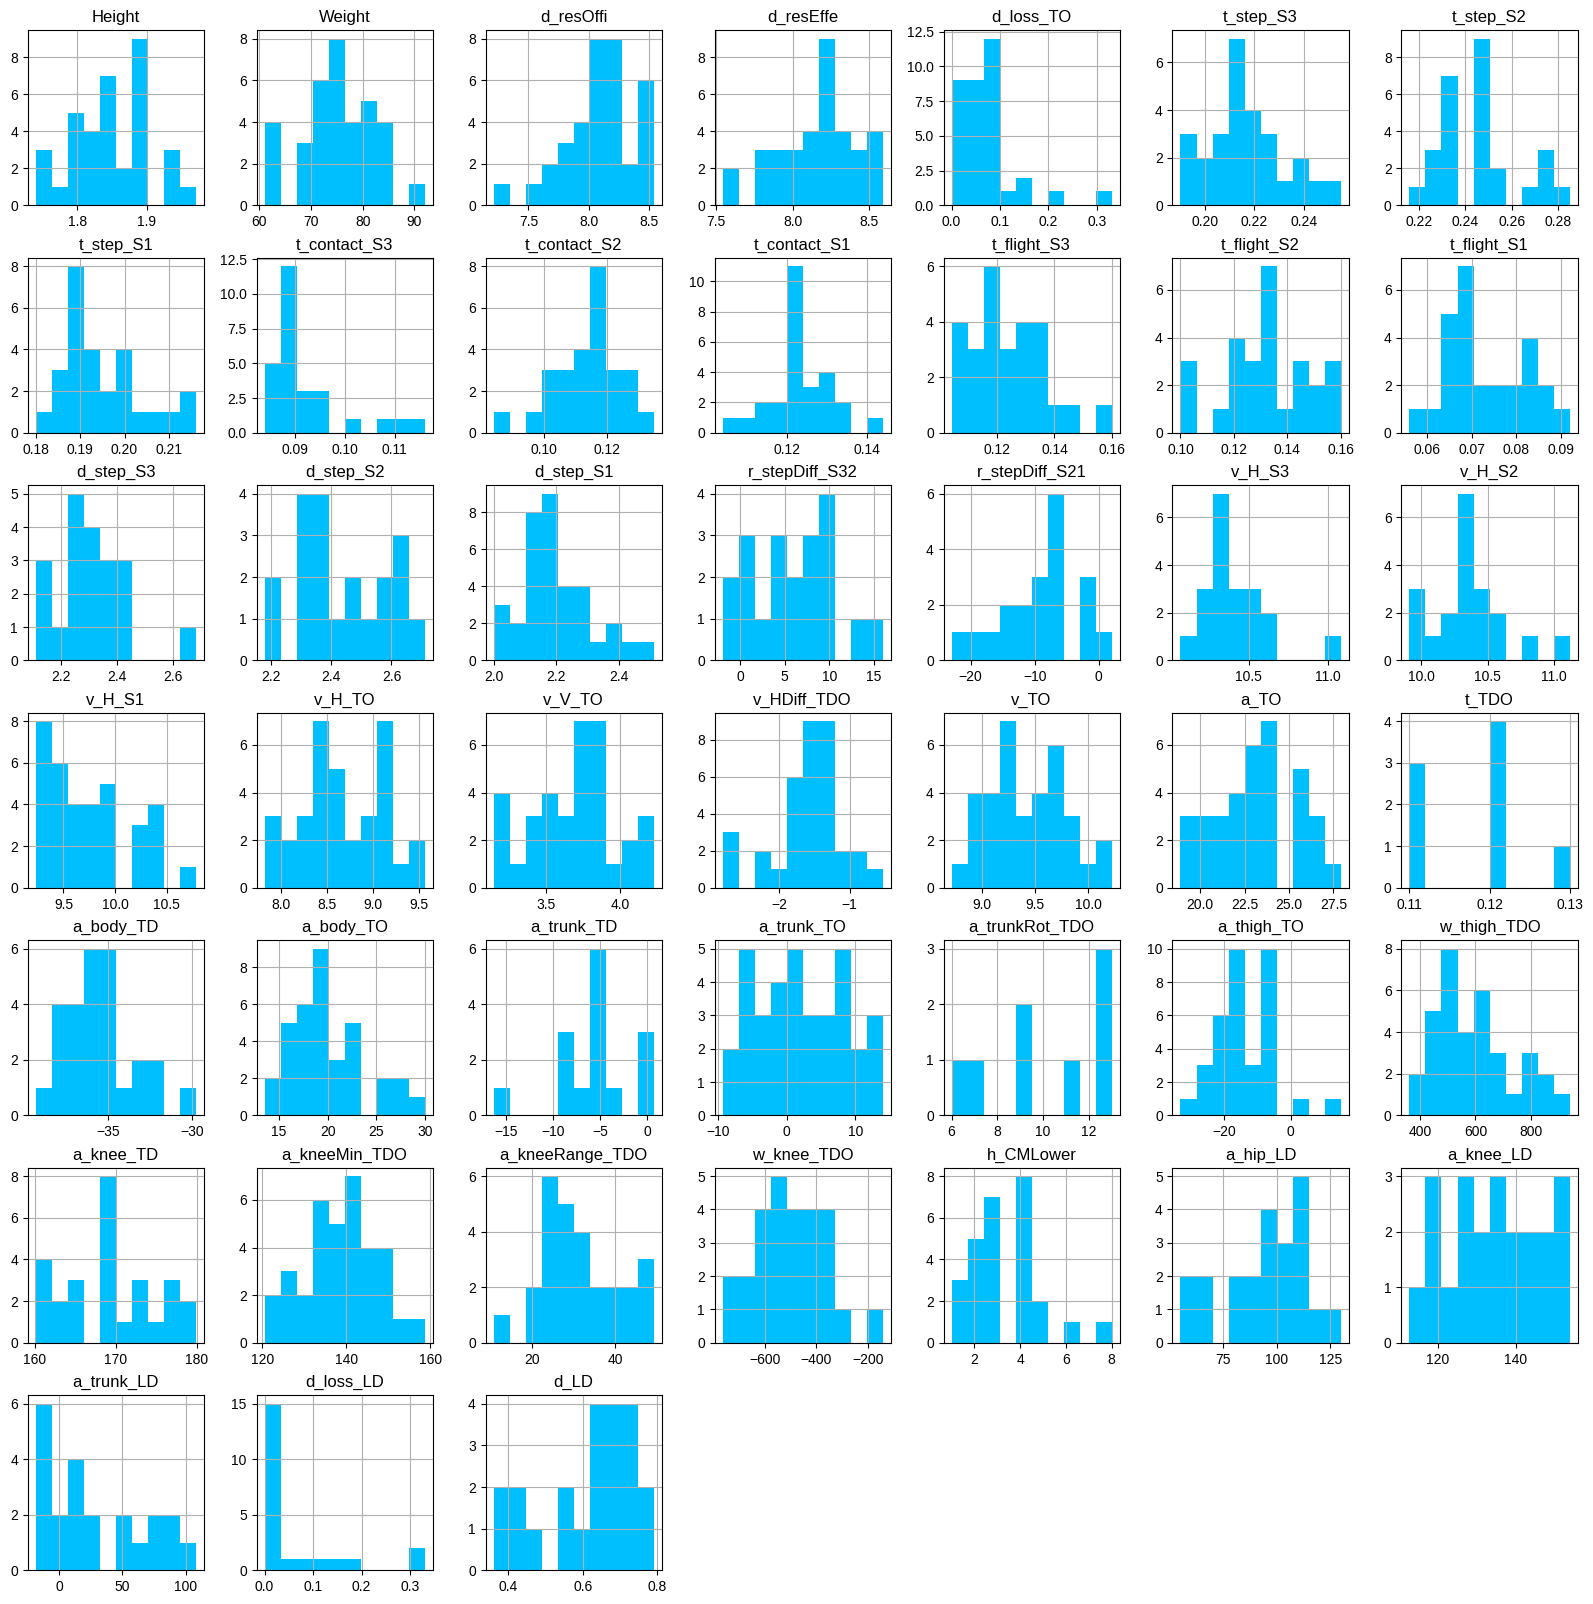

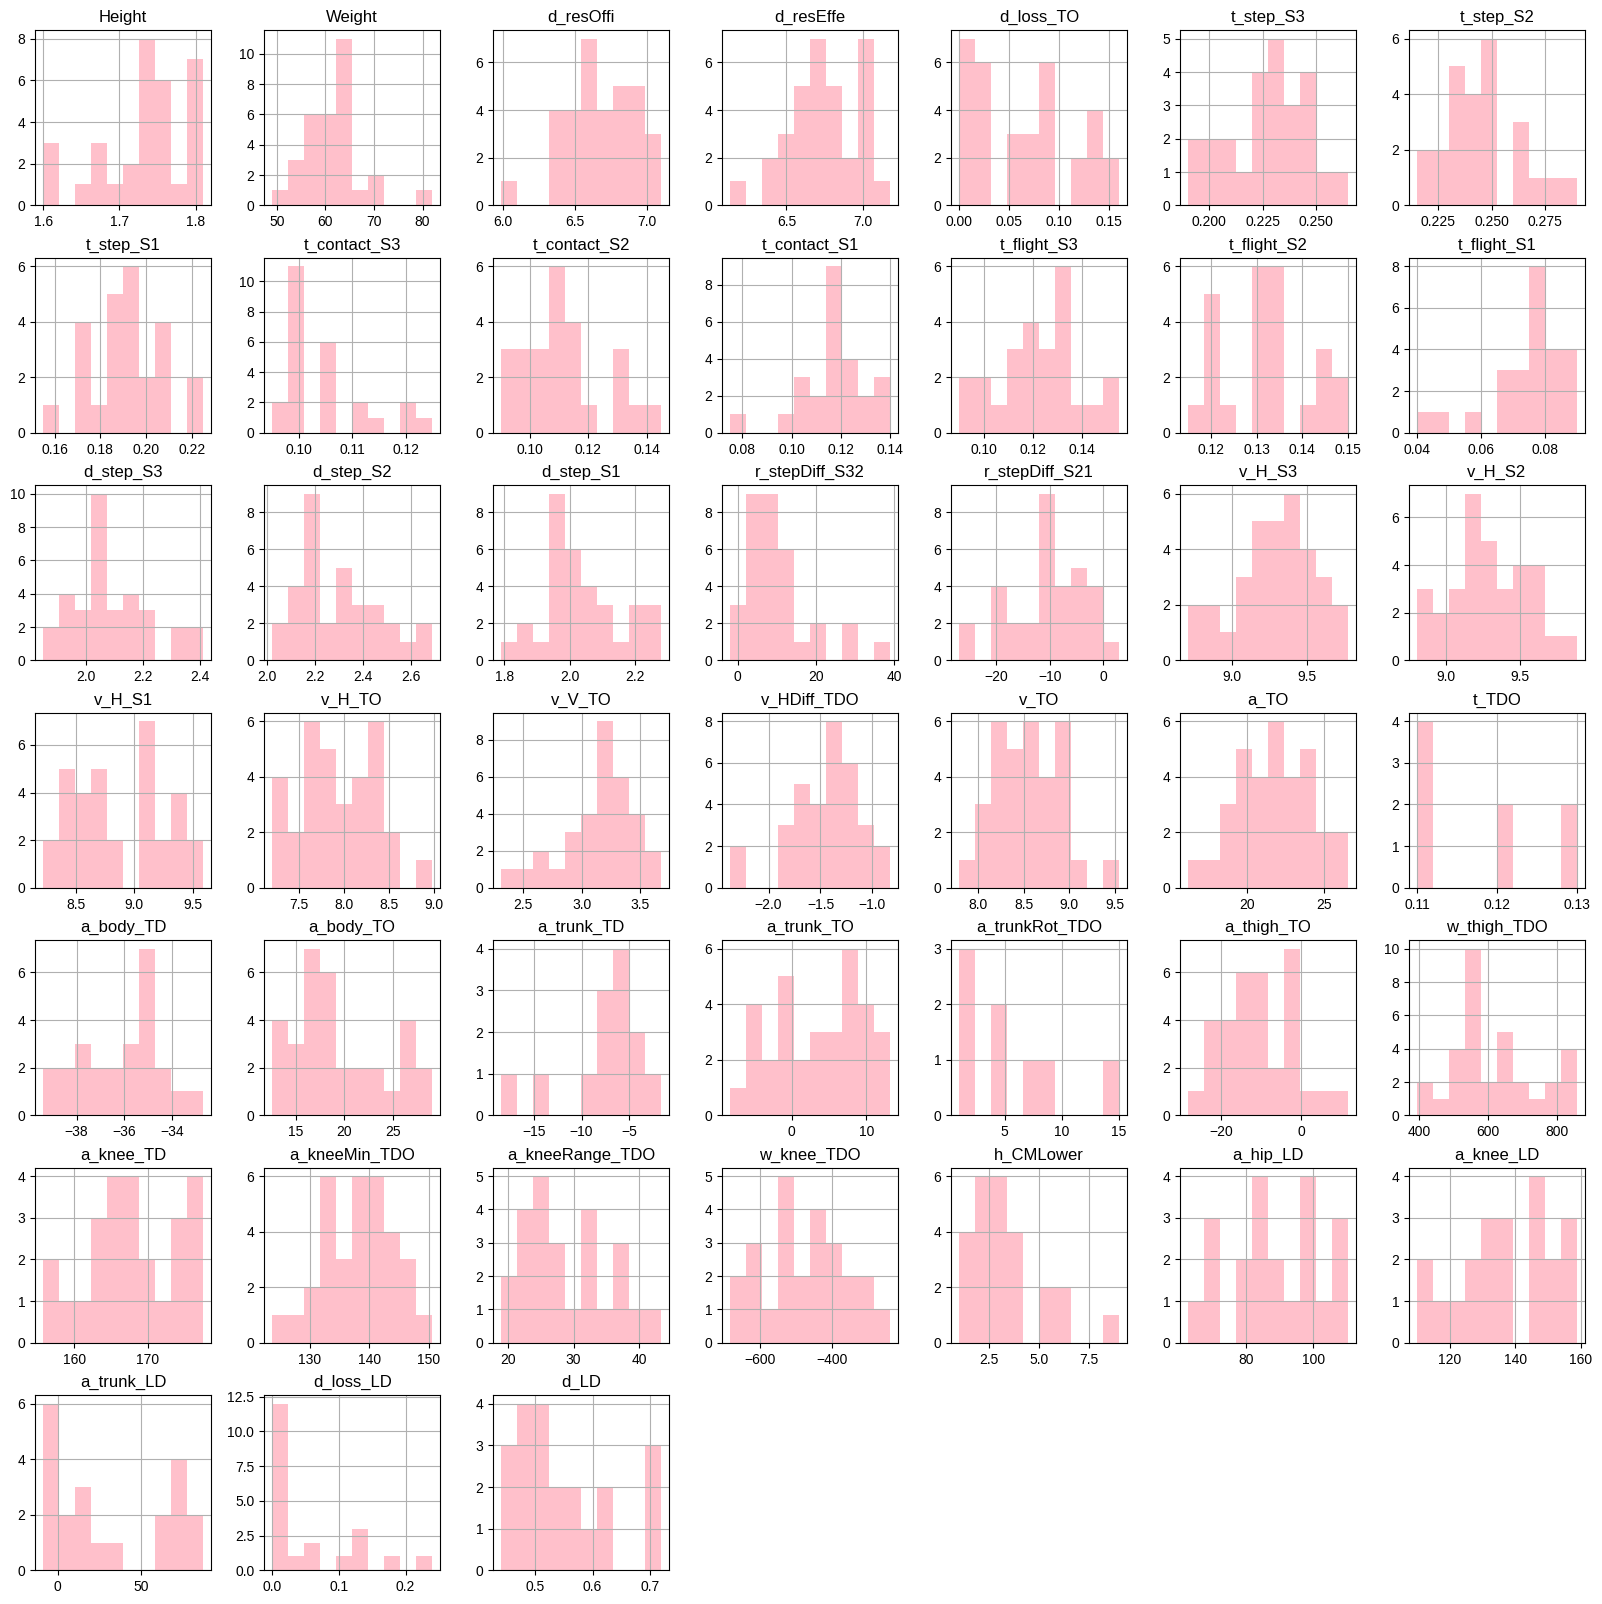

In [4]:
# Missing value distributiotns (percentage)
plt.figure()
missing_ratio_M = raw_data_numerized_M.isnull().sum()/35*100
missing_ratio_M.plot(kind='bar', color='deepskyblue', figsize=(12,4))
plt.xlabel('Feature names')
plt.ylabel("Missing value percentage (%)")
plt.title("Missing features (Men)")

# Missing value distributiotns (counts)
plt.figure()
missing_ratio_F = raw_data_numerized_F.isnull().sum()/33*100
missing_ratio_F.plot(kind='bar', color='pink', figsize=(12,4))
plt.xlabel('Feature names')
plt.ylabel("Missing value percentage (%)")
plt.title("Missing features (Women)")

# Feature distributions:
fig = raw_data_numerized_M.hist(bins = 10, figsize = (20,20), color = 'deepskyblue')
fig = raw_data_numerized_F.hist(bins = 10, figsize = (20,20), color = 'pink')

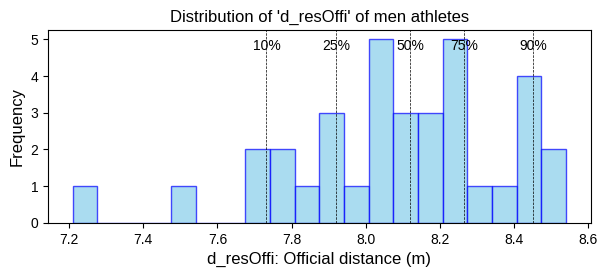

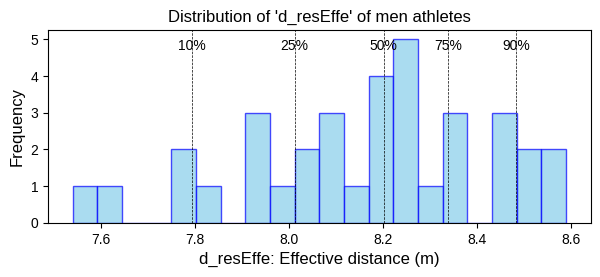

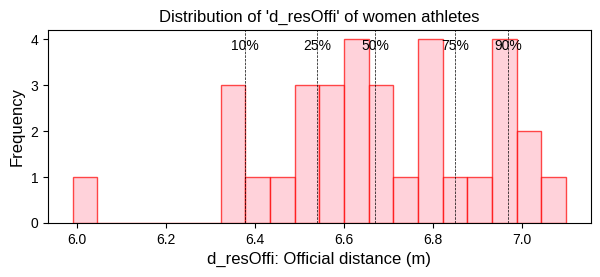

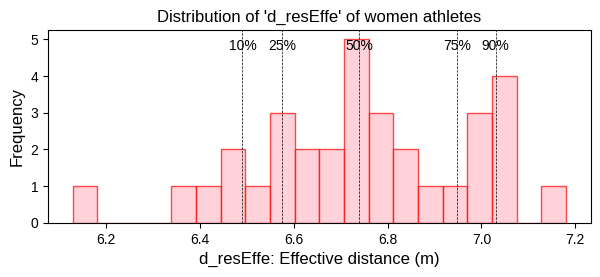

In [23]:
# Plot distributions/quantiles of the target variables (Official & Effective distances)
quantile_list = [0.1, 0.25, 0.5, 0.75, 0.9]

# Plot men athletes' distributions
## OFFICIAL DISTANCE
quantiles_M = raw_data_numerized_M['d_resOffi'].quantile(quantile_list)

# Plot histogram
plt.figure(figsize=(7,2.5))
plt.hist(raw_data_numerized_M['d_resOffi'], bins=20, color='skyblue', edgecolor='blue', alpha=0.7)
plt.title(f'Distribution of \'d_resOffi\' of men athletes', fontsize=12)
plt.xlabel('d_resOffi: Official distance (m)', fontsize=12)  #, fontdict={'fontsize': 12, 'fontname': 'Arial'})
plt.ylabel('Frequency', fontsize=12)  #, fontdict={'fontsize': 12, 'fontname': 'Arial'})

# Highlight the quantiles on the histogram
for i, (quantile, value) in enumerate(quantiles_M.items()):
    plt.axvline(value, color='black', linestyle='--', linewidth=0.5)
    # plt.text(value, plt.ylim()[1] * 0.9 - i*0.3, f'{int(quantile * 100)}%', color='red', ha='center')
    plt.text(value, plt.ylim()[1] * 0.9, f'{int(quantile * 100)}%', color='black', ha='center')


## EFFECTIVE DISTANCE
quantiles_M = raw_data_numerized_M['d_resEffe'].quantile(quantile_list)

# Plot histogram
plt.figure(figsize=(7,2.5))
plt.hist(raw_data_numerized_M['d_resEffe'], bins=20, color='skyblue', edgecolor='blue', alpha=0.7)
plt.title(f'Distribution of \'d_resEffe\' of men athletes', fontsize=12)
plt.xlabel('d_resEffe: Effective distance (m)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Highlight the quantiles on the histogram
for i, (quantile, value) in enumerate(quantiles_M.items()):
    plt.axvline(value, color='black', linestyle='--', linewidth=0.5)
    plt.text(value, plt.ylim()[1] * 0.9, f'{int(quantile * 100)}%', color='black', ha='center')



# Plot women athletes' distributions
## OFFICIAL DISTANCE
quantiles_F = raw_data_numerized_F['d_resOffi'].quantile(quantile_list)

# Plot histogram
plt.figure(figsize=(7,2.5))
plt.hist(raw_data_numerized_F['d_resOffi'], bins=20, color='pink', edgecolor='red', alpha=0.7)
plt.title(f'Distribution of \'d_resOffi\' of women athletes', fontsize=12)
plt.xlabel('d_resOffi: Official distance (m)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Highlight the quantiles on the histogram
for i, (quantile, value) in enumerate(quantiles_F.items()):
    plt.axvline(value, color='black', linestyle='--', linewidth=0.5)
    plt.text(value, plt.ylim()[1] * 0.9, f'{int(quantile * 100)}%', color='black', ha='center')


## EFFECTIVE DISTANCE
quantiles_F = raw_data_numerized_F['d_resEffe'].quantile(quantile_list)

# Plot histogram
plt.figure(figsize=(7,2.5))
plt.hist(raw_data_numerized_F['d_resEffe'], bins=20, color='pink', edgecolor='red', alpha=0.7)
plt.title(f'Distribution of \'d_resEffe\' of women athletes', fontsize=12)
plt.xlabel('d_resEffe: Effective distance (m)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Highlight the quantiles on the histogram
for i, (quantile, value) in enumerate(quantiles_F.items()):
    plt.axvline(value, color='black', linestyle='--', linewidth=0.5)
    plt.text(value, plt.ylim()[1] * 0.9, f'{int(quantile * 100)}%', color='black', ha='center')

# 2. Feature imputation

In [5]:
methods = ['Mean', 'KNN', 'Bayes', 'RF']

In [6]:
X_M_imputed_all = dict()
X_F_imputed_all = dict()

In [7]:
drop_features = ['d_resOffi','d_resEffe',
                 't_TDO', 'a_trunk_TD', 'a_trunkRot_TDO',  # Missing ratio > 50%
                ] 
# 'Duration_TO', 'Trunk_ang_TD','Step_T_last', 'Step_T_2last','Step_T_3last', 'Step_L_diff32', 'Step_L_diff21']
#                ['Duration_TO', 'Trunk_ang_TD', 'Trunk_rot_TO',  # Missing ratio > 50%
#                 'Step_T_last', 'Step_T_2last','Step_T_3last', 'Step_L_diff32', 'Step_L_diff21']

X_M_raw = raw_data_numerized_M.drop(drop_features, axis=1)
X_F_raw = raw_data_numerized_F.drop(drop_features, axis=1)

y_M_effe = raw_data_numerized_M['d_resEffe'].reset_index(drop=True)
y_F_effe = raw_data_numerized_F['d_resEffe'].reset_index(drop=True)

y_M_offi = raw_data_numerized_M['d_resOffi'].reset_index(drop=True)
y_F_offi = raw_data_numerized_F['d_resOffi'].reset_index(drop=True)

## 2.1 SimpleImputer: mean

In [8]:
X_M_imputed_all['Mean'] = X_M_raw.fillna(X_M_raw.mean(), inplace=False)

X_F_imputed_all['Mean'] = X_F_raw.fillna(X_F_raw.mean(), inplace=False)

## 2.2 KNNImputer

In [9]:
knn_imputer = KNNImputer(n_neighbors=2)

data_impKnn_M_np = knn_imputer.fit_transform(X_M_raw)
X_M_imputed_all['KNN'] = pd.DataFrame(data_impKnn_M_np, columns=X_M_raw.columns)

data_impKnn_F_np = knn_imputer.fit_transform(X_F_raw)
X_F_imputed_all['KNN'] = pd.DataFrame(data_impKnn_F_np, columns=X_F_raw.columns)

## 2.3 BayesianRidge

In [10]:
iterative_imputer = IterativeImputer(random_state=0)

#data_impIter_np = iterative_imputer.fit_transform(raw_data_numerized)
#data_impIter = pd.DataFrame(data_impIter_np, columns=raw_data_numerized.columns)


data_impIter_M_np = iterative_imputer.fit_transform(X_M_raw)
X_M_imputed_all['Bayes'] = pd.DataFrame(data_impIter_M_np, columns=X_M_raw.columns)

data_impIter_F_np = iterative_imputer.fit_transform(X_F_raw)
X_F_imputed_all['Bayes'] = pd.DataFrame(data_impIter_F_np, columns=X_F_raw.columns)

/home/qgan/miniconda3/lib/python3.10/site-packages/sklearn/impute/_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/home/qgan/miniconda3/lib/python3.10/site-packages/sklearn/impute/_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


## 2.4 RandomForest

In [11]:
RF_imputer_M = IterativeImputer(random_state=0, max_iter=20, tol=1e-4,
                                estimator=RandomForestRegressor(n_estimators=100,
                                                                max_depth=5,
                                                                max_features='sqrt',
                                                                min_samples_split=5, 
                                                                min_samples_leaf=2,
                                                                random_state=42))

RF_imputer_F = IterativeImputer(random_state=0, max_iter=20, tol=1e-4,
                                estimator=RandomForestRegressor(n_estimators=100,
                                                                max_depth=5,
                                                                max_features='sqrt',
                                                                min_samples_split=5, 
                                                                min_samples_leaf=2,
                                                                random_state=42))


#data_impRF_np = RF_imputer.fit_transform(raw_data_numerized)
#data_impRF = pd.DataFrame(data_impRF_np, columns=raw_data_numerized.columns)


data_impRF_M_np = RF_imputer_M.fit_transform(X_M_raw)
X_M_imputed_all['RF'] = pd.DataFrame(data_impRF_M_np, columns=X_M_raw.columns)

data_impRF_F_np = RF_imputer_F.fit_transform(X_F_raw)
X_F_imputed_all['RF'] = pd.DataFrame(data_impRF_F_np, columns=X_F_raw.columns)

/home/qgan/miniconda3/lib/python3.10/site-packages/sklearn/impute/_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/home/qgan/miniconda3/lib/python3.10/site-packages/sklearn/impute/_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


## 2.5 Evaluation by nested cross-validation
### Comparison of RF performance between imputed and non-imputed data

In [20]:
def nested_CV_RF(X, y, K=4, random_state=42):
    # Parameters: https://xgboost.readthedocs.io/en/latest/parameter.html
    param_grid={'n_estimators': [50, 100, 200],
                'max_depth': [3, 5, 7, 9],
                'max_features': [1, 3, 6, 10]
               }
    #pinball_loss = make_scorer(mean_pinball_loss, alpha=quantile)
    mse_scorer = make_scorer(mean_squared_error)
    inner_cv = KFold(n_splits=K-1, shuffle=True, random_state=random_state)
    outer_cv = KFold(n_splits=K, shuffle=True, random_state=random_state)
    
    start_time = time.time()  # Recording execution time
    
    reg = GridSearchCV(estimator=RandomForestRegressor(random_state=random_state), 
                       param_grid=param_grid, cv=inner_cv, scoring=mse_scorer)
    
    nested_score = cross_val_score(reg, X=X, y=y, cv=outer_cv, scoring=mse_scorer)
    
    end_time = time.time()  # Recording execution time
    print("Execution time:", end_time - start_time, "s")
    
    return np.mean(nested_score)

In [21]:
for m in methods:
    print(m)
    print(nested_CV_RF(X_M_imputed_all[m], y_M_effe, K=4, random_state=42))

Mean
Execution time: 31.835209608078003 s
0.04627029972747362
KNN
Execution time: 32.61423635482788 s
0.05030209132151952
Bayes
Execution time: 32.8119170665741 s
0.049915490581543355
RF
Execution time: 32.76123666763306 s
0.0439579475496735


In [23]:
for m in methods:
    print(m)
    print(nested_CV_RF(X_F_imputed_all[m], y_F_effe, K=4, random_state=42))

Mean
Execution time: 33.2853045463562 s
0.04268180884007473
KNN
Execution time: 32.906861782073975 s
0.040833226602939525
Bayes
Execution time: 33.36289882659912 s
0.04139502995518783
RF
Execution time: 32.65849566459656 s
0.04655451632574492


# Save results

In [24]:
# df.to_csv('data.csv', index=False)

data_M_imp = pd.concat([X_M_imputed_all['RF'], y_M_effe, y_M_offi], axis=1)
data_F_imp = pd.concat([X_F_imputed_all['KNN'], y_F_effe, y_F_offi], axis=1)

In [25]:
data_M_imp.to_csv('../dataset/data_M_imp.csv', index=False)
data_F_imp.to_csv('../dataset/data_F_imp.csv', index=False)